In [1]:
import os, shutil

import numpy as np
import pandas as pd
import xarray as xr
from datetime import timedelta, datetime
import geopandas
from parcels import FieldSet, ParticleSet, ParticleFile, plotTrajectoriesFile
from parcels import JITParticle, ScipyParticle

%matplotlib inline
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#cluster = LocalCluster(processes=False, n_workers=4, threads_per_worker=2)
#
from dask_jobqueue import PBSCluster
# ** processes and cores may be adjusted in order to have more memory or inversely more computational ressource
cluster = PBSCluster(processes=5, cores=5, walltime='04:00:00')
#cluster = PBSCluster(walltime='04:00:00')
#cluster = PBSCluster()
w = cluster.scale(jobs=1)
#
client = Client(cluster)
client

Client Scheduler: tcp://10.148.1.87:38848 Dashboard: http://10.148.1.87:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
#root_dir = '/home1/dunree/slgentil/tmp/parcels/'
root_dir = '/home1/scratch/aponte/parcels/'

run_name = 'test4'
run_dir = root_dir+run_name
N_tiles = 25
restart = True

tile_data_dirs = [os.path.join(run_dir,'data_{:03d}'.format(t)) 
                  for t in range(N_tiles)
                 ]

In [4]:
%%time
import glob
pd.set_option("display.max_rows", 100, "display.max_columns", None)
#find files floats_*.nc in all tiles
float_files = []
for dir in tile_data_dirs[:N_tiles]:
    float_files.extend(glob.glob(dir+"/floats_000_*.nc"))
    float_files.extend(glob.glob(dir+"/floats_001_*.nc"))

df = pd.concat([xr.open_dataset(file).to_dataframe() 
                for file in float_files])
df.head()

CPU times: user 6.81 s, sys: 5.05 s, total: 11.9 s
Wall time: 11.8 s


trajectory       time        lat        lon    z
obs traj                                                  
0   0      1000000.0 2011-11-15 -72.239326 -37.003365  0.0
    1      1000001.0 2011-11-15 -72.150612 -36.998806  0.0
    2      1000002.0 2011-11-15 -72.061745 -36.994457  0.0
    3      1000003.0 2011-11-15 -71.972725 -36.990318  0.0
    4      1000004.0 2011-11-15 -71.883560 -36.986385  0.0

In [5]:
dft = df.groupby(['trajectory'])
print('Nb total de trajectoires=',len(dft.groups.keys()))

Nb total de trajectoires= 1244107


In [6]:
dfd = df.groupby(['time'])
print('Nb total de dates=',len(dfd.groups.keys()))
print('from: ',list(dfd.groups.keys())[0],' to ', list(dfd.groups.keys())[-1])

Nb total de dates= 49
from:  2011-11-15 00:00:00  to  2011-11-17 00:00:00


In [31]:
lost = dft.filter(lambda x: len(x) < len(dfd.groups.keys()))
lost.head(10)

49


trajectory                time        lat        lon    z
obs traj                                                           
0   1359   4001359.0 2011-11-15 00:00:00  65.169167 -36.072407  0.0
    1806   4001806.0 2011-11-15 00:00:00  65.179398 -35.721432  0.0
    2034   4002034.0 2011-11-15 00:00:00  65.385574 -35.585629  0.0
    3179   4003179.0 2011-11-15 00:00:00  65.812859 -34.832275  0.0
    3408   4003408.0 2011-11-15 00:00:00  65.822433 -34.662479  0.0
1   1359   4001359.0 2011-11-15 01:00:00  65.167987 -36.107814  0.0
    1806   4001806.0 2011-11-15 01:00:00  65.176312 -35.739591  0.0
    2034   4002034.0 2011-11-15 01:00:00  65.377425 -35.612578  0.0
    3179   4003179.0 2011-11-15 01:00:00  65.817836 -34.902930  0.0
    3408   4003408.0 2011-11-15 01:00:00  65.829482 -34.728416  0.0

In [8]:
nb_dates = dft["time"].count()
lost = nb_dates[nb_dates > 25][nb_dates < len(dfd.groups.keys())]
print(lost)

trajectory
4001360.0     45
4001804.0     45
4001808.0     41
4001812.0     43
4001813.0     47
              ..
24036008.0    34
24036010.0    41
24036043.0    28
24036056.0    34
24036079.0    34
Name: time, Length: 228, dtype: int64


In [9]:
traj = dft.get_group(lost.index[0])
print(traj)

          trajectory                time        lat        lon    z
obs traj                                                           
0   1360   4001360.0 2011-11-15 00:00:00  65.236198 -36.082783  0.0
1   1360   4001360.0 2011-11-15 01:00:00  65.236494 -36.093577  0.0
2   1360   4001360.0 2011-11-15 02:00:00  65.237960 -36.103338  0.0
3   1360   4001360.0 2011-11-15 03:00:00  65.240834 -36.114612  0.0
4   1360   4001360.0 2011-11-15 04:00:00  65.243612 -36.125486  0.0
5   1360   4001360.0 2011-11-15 05:00:00  65.246750 -36.134579  0.0
6   1360   4001360.0 2011-11-15 06:00:00  65.249729 -36.142551  0.0
7   1360   4001360.0 2011-11-15 07:00:00  65.252785 -36.148307  0.0
8   1360   4001360.0 2011-11-15 08:00:00  65.255075 -36.153157  0.0
9   1360   4001360.0 2011-11-15 09:00:00  65.256900 -36.156427  0.0
10  1360   4001360.0 2011-11-15 10:00:00  65.258609 -36.157688  0.0
11  1360   4001360.0 2011-11-15 11:00:00  65.258824 -36.158288  0.0
12  1360   4001360.0 2011-11-15 12:00:00  65.257

In [10]:
lon = traj.sort_values('time').drop_duplicates(subset=['time'])['lon'].values
lat = traj.sort_values('time').drop_duplicates(subset=['time'])['lat'].values
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([min(lon)-10, max(lon)+10, min(lat)-10, max(lat)+10])

ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.plot(lon, lat, '.')
#ax.set_title('France');

/home1/datahome/slgentil/conda-env/equinox/lib/python3.8/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_ocean.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


URLError: <urlopen error [Errno 101] Network is unreachable>

<Figure size 504x504 with 1 Axes>

In [13]:
dummy = df.loc[(df['lon'] >= -15) & (df['lon'] <= 15) & 
               (df['lat'] >= -15) & (df['lat'] <= 15)]['trajectory'].unique()
print(dummy)

[2027005. 2027006. 2027007. ... 3013390. 3011617. 3015184.]


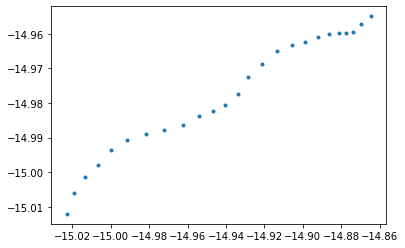

In [65]:
lon = traj.sort_values('time').drop_duplicates(subset=['time'])['lon'].values
lat = traj.sort_values('time').drop_duplicates(subset=['time'])['lat'].values
plt.plot(myflt.lon,myflt.lat,'.')

In [19]:
# create dataframe with all uncomplete trajectories
traj = df['trajectory'].dropna().sort_values().unique()
print(traj.size)
date = df['time'].dropna().sort_values().unique()
print(date.size)
lost = None
keep = None
for id in traj[:1000]:
    _lost = df.loc[df['trajectory']== int(id)].sort_values('time').drop_duplicates(subset=['time'])
    if len(_lost.index) != date.size:
        if lost is None:
            lost = _lost
        else:
            lost = pd.concat([lost,_lost])
    else:
        if keep is None:
            keep = _lost
        else:
            keep = pd.concat([keep,_lost])
print('nb de trajectoires complètes:',keep['trajectory'].unique().size)
print('nb de trajectoires incomplètes:',lost['trajectory'].unique().size)

TypeError: 'bool' object is not callable

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

trajind = keep['trajectory'][0].values
print("keep trajectory : ", trajind)
trajlost = lost['trajectory'].dropna().sort_values().unique()
lon = keep.loc[keep['trajectory']== trajind].sort_values('time').drop_duplicates(subset=['time'])['lon'].values
lat = lost.loc[lost['trajectory']== trajind].sort_values('time').drop_duplicates(subset=['time'])['lat'].values
print(lon.size)
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([min(lon)-20, max(lon)+20, min(lat)-10, max(lat)+10])

ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.plot(lon, lat, '.')

In [8]:
df = pd.read_csv('/home1/scratch/aponte/parcels/test3/data_022/floats_assigned_008_022.csv', index_col=0)
print(len(df.index))
print(df['id'].unique().size)

574
573


In [9]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
